In [1]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np
from IPython import display
from matplotlib import pyplot as plt

In [2]:
transform = transforms.Compose([transforms.Resize((64, 64)), transforms.ToTensor()])

In [3]:
trainset = ImageFolder(root='.', transform=transform)
train_data = torch.utils.data.DataLoader(trainset, batch_size=16,
                                          shuffle=True, num_workers=2)


In [4]:
z_size = 512
class Decoder(nn.Module):
    '''
        Generative Network
    '''
    def __init__(self, z_size=z_size, out_size=3, ngf=192):
        super(Decoder, self).__init__()
        self.z_size = z_size
        self.ngf = ngf
        self.out_size = out_size

        self.main = nn.Sequential(
            # input size is z_size
            nn.ConvTranspose2d(self.z_size, self.ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(self.ngf * 8),
            nn.ReLU(inplace=True),
            # state size: (ngf * 8) x 4 x 4
            nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 4),
            nn.ReLU(inplace=True),
            # state size: (ngf * 4) x 8 x 8
            nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf * 2),
            nn.ReLU(inplace=True),
            # state size: (ngf * 2) x 16 x 16
            nn.ConvTranspose2d(self.ngf * 2, self.ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ngf),
            nn.ReLU(inplace=True),
            # state size: ngf x 32 x 32
            nn.ConvTranspose2d(self.ngf, self.out_size, 4, 2, 1, bias=False),
            nn.Sigmoid()
            # state size: out_size x 64 x 64
        )

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, input):

        output = self.main(input)

        return output
    

class Encoder(nn.Module):
    '''
        Discriminative Network
    '''
    def __init__(self, in_size=3, ndf=192):
        super(Encoder, self).__init__()
        self.in_size = in_size
        self.ndf = ndf

        self.main = nn.Sequential(
            # input size is in_size x 64 x 64
            nn.Conv2d(self.in_size, self.ndf, 4, 2, 1, bias=False),
            nn.ReLU(inplace=True),
            # state size: ndf x 32 x 32
            nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 2),
            nn.ReLU(inplace=True),
            # state size: (ndf * 2) x 16 x 16
            nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 4),
            nn.ReLU(inplace=True),
            # state size: (ndf * 4) x 8 x 8
            nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(self.ndf * 8),
            nn.ReLU(inplace=True),
            # state size: (ndf * 8) x 4 x 4
            nn.Conv2d(self.ndf * 8, self.ndf, 4, 1, 0, bias=False),
            nn.Sigmoid()
            # state size: 1 x 1 x 1
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0.0, 0.02)
                if m.bias is not None:
                    m.bias.data.zero_()
                    
        self.lin_mu = nn.Linear(self.ndf, z_size)
        self.lin_logvar = nn.Linear(self.ndf, z_size)
        
    def forward(self, input):

        output = self.main(input)
        mu = self.lin_mu(output.view(-1, self.ndf))
        logvar = self.lin_logvar(output.view(-1, self.ndf))

        return mu, logvar
    
class CAE(nn.Module):
    def __init__(self):
        super(CAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        mu, logvar = self.encoder(x)
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = eps.mul(std).add_(mu)
        reconstructed = self.decoder(z.view(-1, z_size, 1, 1))
        
        return mu, logvar, reconstructed

In [5]:
model = CAE()

In [6]:
model(next(iter(train_data))[0])

(tensor([[-4.4508e-01,  1.2450e-01, -2.9661e-01,  ..., -1.5555e-01,
          -1.9128e-01, -2.3468e-02],
         [-5.8656e-01,  1.9356e-01, -4.1978e-01,  ..., -1.0314e-01,
          -2.0254e-01,  2.6838e-01],
         [-5.2012e-01,  1.6553e-01, -2.0739e-01,  ..., -1.6692e-01,
          -1.2917e-01,  6.9201e-02],
         ...,
         [-6.3526e-01,  2.7173e-01, -2.9231e-01,  ...,  1.2581e-02,
          -1.2427e-01,  1.5035e-01],
         [-6.0962e-01,  9.7893e-02, -3.3827e-01,  ..., -3.1689e-02,
          -2.5516e-01,  2.0251e-01],
         [-6.0646e-01,  2.2274e-01, -3.9847e-02,  ...,  4.9394e-02,
          -2.1007e-01,  1.6263e-01]]),
 tensor([[-5.5645e-02, -1.0790e-01,  7.1155e-01,  ..., -5.3856e-02,
          -3.4318e-01,  3.1212e-01],
         [-8.9380e-02, -8.8625e-02,  7.4622e-01,  ..., -1.9942e-01,
          -4.9213e-01,  4.6603e-01],
         [ 4.0949e-03, -1.2575e-01,  8.1666e-01,  ...,  3.2859e-02,
          -2.6767e-01,  3.9606e-01],
         ...,
         [ 7.4984e-02, -4

In [7]:
train_loss, val_acc, train_acc = list(), list(), list()

def loss_function(recon_x, x, mu, logvar, alpha=1):
    BCE = F.binary_cross_entropy(recon_x, x)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + alpha*KLD

network = CAE()
params = [param for param in network.parameters() if param.requires_grad]
optimizer = torch.optim.Adam(params)
# criterion = nn.CrossEntropyLoss()
epoch = 0
mse_criterion = nn.MSELoss()
ce_criterion = nn.CrossEntropyLoss()

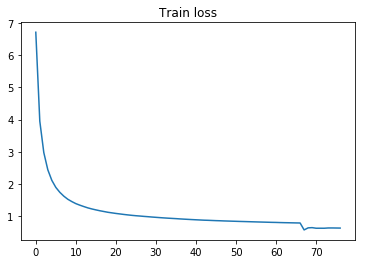

Process Process-16:
Process Process-15:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/usr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    samples

Loss: 0.628305071592331


  File "/usr/lib/python3.6/site-packages/PIL/Image.py", line 2552, in open
    prefix = fp.read(16)
KeyboardInterrupt
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7faa51244358>>
Traceback (most recent call last):
  File "/usr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 347, in __del__
    def __del__(self):
  File "/usr/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 178, in handler
    _error_if_any_worker_fails()
RuntimeError: DataLoader worker (pid 7656) exited unexpectedly with exit code 1.


KeyboardInterrupt: 

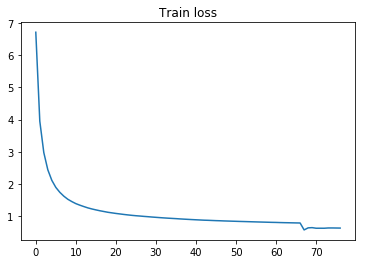

In [19]:
while True:
    print("Epoch", epoch)
    network.train(True)
    
    epoch_loss = []
    
    for X_batch in train_data:
        X_batch = X_batch[0]
        mu, logvar, reconstructed = network(Variable(X_batch))
        
        loss = loss_function(reconstructed, X_batch, mu, logvar, 0.01)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        try:
            epoch_loss.append(loss.data.item())
        except:
            epoch_loss.append(loss.data.numpy()[0])

        train_loss.append(np.mean(epoch_loss))
        plt.clf()

        plt.plot(train_loss[-100:])
        plt.title('Train loss')
        display.clear_output(wait=True)
        display.display(plt.gcf())

        print("Loss: {}".format(train_loss[-1]))
        
        epoch += 1

In [ ]:
40*31*23*64

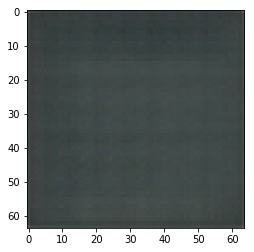

In [17]:
c = next(iter(train_data))[0]
mu, sigma, a = network(c)
# print(a)
a = a[0].permute(1, 2, 0)

# print(a.shape)
a = a.cpu().detach().numpy()
b = np.clip(a, 0, 1)
plt.imshow(b)

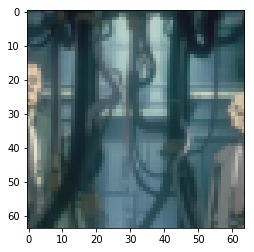

In [18]:
plt.imshow(c[0].permute(1, 2, 0))

In [ ]:
from copy import deepcopy

model = deepcopy(network)

In [ ]:
modules = list(iter(model.modules()))[10:]

In [ ]:
modules

In [ ]:
# one = torch.zeros(1, 100)
it = 0
# p= torch.rand(1, 1000)
p = torch.zeros(1, 500)
p[0, np.random.randint(10)] = 1
while True:
    q = torch.rand(1, 500)
#     q = torch.zeros(1, 1000)
#     q[0, np.random.randint(00)] = 1

    relu = nn.ReLU()
    for i in np.arange(0, 1, 0.1):
    # one[0, 5]
        it += 1
        r = p*(1-i) + q*i
        x = modules[0](r)
        x = relu(x)
        x = x.view(1, 40, 8, 8)
        x = modules[1](x)

        x = modules[2](x)
        x = relu(x)
        x = modules[3](x)
        x = modules[4](x)
        x = relu(x)
        x = modules[5](x)
        x = modules[6](x)

        print(x[0].shape)
        a = x[0].permute(1, 2, 0)

        print(a.shape)
        a = a.cpu().detach().numpy()
        b = np.clip(a, 0, 1)
        
        display.clear_output(wait=True)
        plt.imshow(b)

#         fig, ax = plt.subplots(figsize=(3, 3))
# #         fig.savefig("{:4d}".format(it)+".png", dpi=fig.dpi)
#     #     plt.show()

        display.display(plt.gcf())
    p = q

In [ ]:
40*8*8

In [ ]:
torch.rand(1)

In [ ]:
y_onehot

In [ ]:
x.view(x.size(0), 1)

In [ ]:
t[[0, 1]]

In [ ]:
x.v

In [ ]:
t[[1,2, 3, 4]] = 1

In [ ]:
t[a, 0] = 1

In [ ]:
t

In [ ]:
optimizer.param_groups[0]['lr'] = 0.0001